## Data Transformations from Bronze to Silver

In [2]:
# Read the bronze table
df_bronze = spark.read.table("bronze")

display(df_bronze)

# Convert PySpark dataframe to Pandas dataframe
# df_bronze_pd = df_bronze.toPandas()

# Show first 5 rows
# df_bronze_pd.head()

# Show list of columns
# df_bronze_pd.columns

StatementMeta(, c570839b-bb19-4093-9741-7cad85615e53, 4, Finished, Available, Finished)

SynapseWidget(Synapse.DataFrame, cd46bae6-42ed-4f97-a642-d78e5df6d1bb)

In [3]:
# Import functions needed
from pyspark.sql.functions import when, concat_ws, col


# Create an AgeGroup Column, instead of pivoted Age Group columns
#  Categorizes customers into Under 30, 30-59, 60+
df_silver = df_bronze.withColumn(
    "AgeGroup",
    when(col("Age") < 30, "Under 30")
    .when((col("Age") >= 30) & (col("Age") < 60), "30-59")
    .otherwise("60+")
)


# Create a HighRevenue customer column
# Flags high-value customers based on MonthlyCharge.
df_silver = df_silver.withColumn(
    "HighRevenueCustomer",
    when(col("MonthlyCharge") > 100, "High Value").otherwise("Regular")
)

# Handle missing Churn Reason (if any)
df_silver = df_silver.fillna({"ChurnReason": "No Churn"})

display(df_silver)


StatementMeta(, c570839b-bb19-4093-9741-7cad85615e53, 5, Finished, Available, Finished)

SynapseWidget(Synapse.DataFrame, 2bdbad30-9356-42ab-8f23-5f24c612a839)

In [ ]:
%%sql
-- or use spark sql
-- Register bronze table as a temporary view
df_bronze.createOrReplaceTempView("bronze")

-- Run SQL transformation
df_silver = spark.sql("""
    SELECT *,
        CASE 
            WHEN Age < 30 THEN 'Under 30'
            WHEN Age >= 30 AND Age < 60 THEN '30-59'
            ELSE '60+'
        END AS AgeGroup,
        
        CASE 
            WHEN MonthlyCharge > 100 THEN 'High Value'
            ELSE 'Regular'
        END AS HighRevenueCustomer,
        
        COALESCE(ChurnReason, 'No Churn') AS ChurnReason
    FROM bronze
""")



In [4]:
# Save silver layer table 
# This writes the final silver table, clean with transformations, ready for use
df_silver.write.mode("overwrite").saveAsTable("silver")


StatementMeta(, c570839b-bb19-4093-9741-7cad85615e53, 6, Finished, Available, Finished)

## Exploratory Data Analysis

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# For styling -> set the grid to white
sns.set(style="whitegrid")

# Read the Spark table
df_silver = spark.read.table("silver")

# Convert to Pandas for easier EDA
df_silver_pd = df_silver.toPandas()

# Preview the first few rows
df_silver_pd.head()

StatementMeta(, c570839b-bb19-4093-9741-7cad85615e53, 7, Finished, Available, Finished)

,CustomerID,ChurnLabel,AccountLength,LocalCalls,LocalMins,IntlCalls,IntlMins,IntlActive,IntlPlan,ExtraInternationalCharges,...,NumberofCustomersinGroup,DeviceProtection&OnlineBackup,ContractType,PaymentMethod,MonthlyCharge,TotalCharges,ChurnCategory,ChurnReason,AgeGroup,HighRevenueCustomer
0,2046-VRMT,Yes,1,4,12.0,4,12.3,Yes,no,2,...,0,No,Month-to-Month,Direct Debit,40,40,Attitude,Attitude of support person,60+,Regular
1,9486-APOG,Yes,1,6,14.0,4,12.5,Yes,no,2,...,0,No,Month-to-Month,Direct Debit,26,26,Competitor,Competitor had better devices,30-59,Regular
2,8875-NPDU,Yes,1,7,15.0,4,9.1,Yes,no,2,...,0,No,Month-to-Month,Credit Card,22,22,Other,Don't know,30-59,Regular
3,0666-PMDU,Yes,1,4,8.0,4,12.1,Yes,no,2,...,0,No,Month-to-Month,Direct Debit,34,34,Dissatisfaction,Network reliability,Under 30,Regular
4,8173-IKVF,Yes,1,6,15.0,4,10.8,Yes,no,2,...,0,No,Month-to-Month,Direct Debit,32,32,Dissatisfaction,Product dissatisfaction,Under 30,Regular


### Explore Data Stucture

In [6]:
# Shape: How many rows and columns
print(f"Rows: {df_silver_pd.shape[0]}, Columns: {df_silver_pd.shape[1]}")

# Data types of each column
print("\nData Types:")
print(df_silver_pd.dtypes)

# Missing values check
print("\nMissing Values:")
print(df_silver_pd.isnull().sum())

StatementMeta(, c570839b-bb19-4093-9741-7cad85615e53, 8, Finished, Available, Finished)

Rows: 6687, Columns: 31

Data Types:
CustomerID                        object
ChurnLabel                        object
AccountLength                      int64
LocalCalls                         int64
LocalMins                        float64
IntlCalls                          int64
IntlMins                         float64
IntlActive                        object
IntlPlan                          object
ExtraInternationalCharges          int64
CustomerServiceCalls               int64
AvgMonthlyGBDownload               int64
UnlimitedDataPlan                 object
ExtraDataCharges                   int64
State                             object
PhoneNumber                       object
Gender                            object
Age                                int64
Under30                           object
Senior                            object
Group                             object
NumberofCustomersinGroup           int64
DeviceProtection&OnlineBackup     object
ContractType        

In [7]:
# Basic descriptive stats (mean, std, min, max, percentiles)
df_silver_pd.describe()

StatementMeta(, c570839b-bb19-4093-9741-7cad85615e53, 9, Finished, Available, Finished)

,AccountLength,LocalCalls,LocalMins,IntlCalls,IntlMins,ExtraInternationalCharges,CustomerServiceCalls,AvgMonthlyGBDownload,ExtraDataCharges,Age,NumberofCustomersinGroup,MonthlyCharge,TotalCharges
count,6687.000000,6687.000000,6687.000000,6687.000000,6687.000000,6687.000000,6687.000000,6687.000000,6687.000000,6687.000000,6687.000000,6687.000000,6687.000000
mean,32.337820,130.974129,322.752864,51.097802,130.070624,33.642889,0.915657,6.696276,3.374458,47.448632,0.837894,31.030357,1083.755645
std,24.595689,121.893966,288.619931,103.592440,243.527828,76.348332,1.411484,7.454339,12.565309,16.969893,1.700780,16.288147,1127.074863
min,1.000000,1.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,19.000000,0.000000,5.000000,6.000000
25%,9.000000,31.000000,76.900000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,33.000000,0.000000,16.000000,181.000000
50%,29.000000,98.000000,250.500000,0.000000,0.000000,0.000000,0.000000,5.000000,0.000000,47.000000,0.000000,31.000000,647.000000
75%,55.000000,199.000000,498.050000,52.000000,140.400000,16.000000,2.000000,9.000000,0.000000,60.000000,0.000000,43.000000,1732.500000
max,77.000000,918.000000,1234.200000,1120.000000,1372.500000,586.000000,5.000000,43.000000,99.000000,85.000000,6.000000,78.000000,5574.000000


### Distribution Analysis

StatementMeta(, c570839b-bb19-4093-9741-7cad85615e53, 10, Finished, Available, Finished)

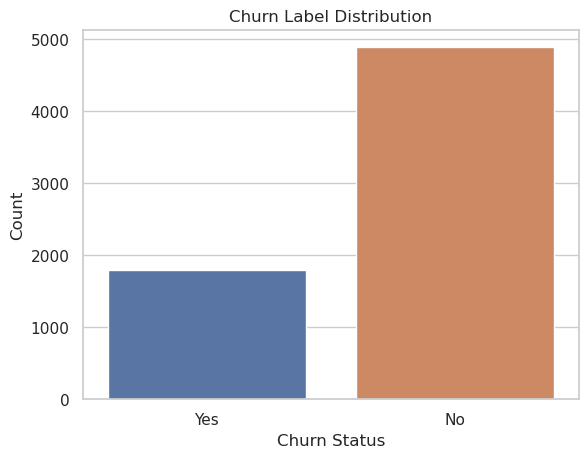

In [8]:
# Churn Label distribution
sns.countplot(x='ChurnLabel', data=df_silver_pd)
plt.title('Churn Label Distribution')
plt.xlabel('Churn Status')
plt.ylabel('Count')
plt.show()

StatementMeta(, c570839b-bb19-4093-9741-7cad85615e53, 11, Finished, Available, Finished)

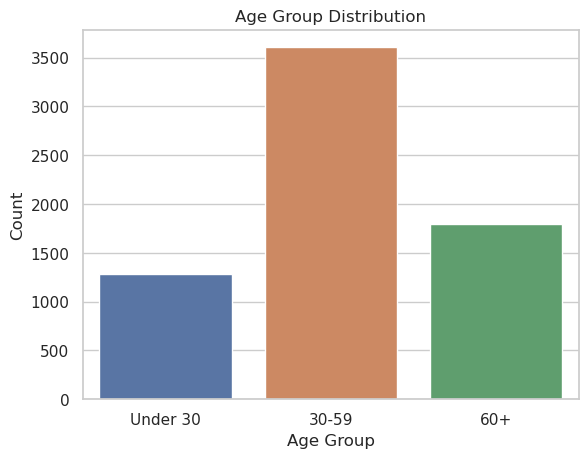

In [9]:

# Age Group distribution
sns.countplot(x='AgeGroup', data=df_silver_pd, order=["Under 30", "30-59", "60+"])
plt.title('Age Group Distribution')
plt.xlabel('Age Group')
plt.ylabel('Count')
plt.show()


StatementMeta(, c570839b-bb19-4093-9741-7cad85615e53, 12, Finished, Available, Finished)

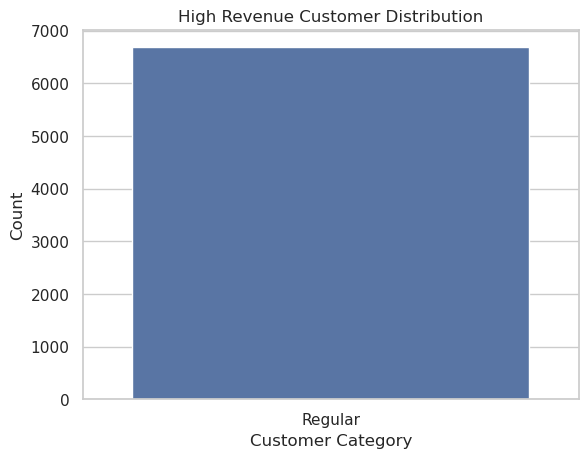

In [10]:

# High Revenue Customer distribution
sns.countplot(x='HighRevenueCustomer', data=df_silver_pd)
plt.title('High Revenue Customer Distribution')
plt.xlabel('Customer Category')
plt.ylabel('Count')
plt.show()

StatementMeta(, c570839b-bb19-4093-9741-7cad85615e53, 13, Finished, Available, Finished)

/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


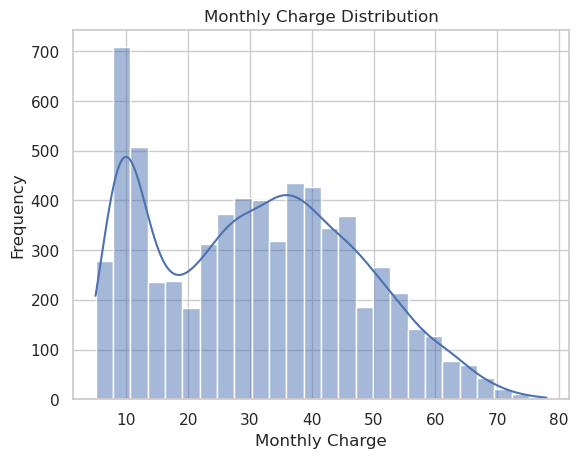

In [11]:
# Distribution of Monthly Charges
sns.histplot(df_silver_pd['MonthlyCharge'], kde=True)
plt.title('Monthly Charge Distribution')
plt.xlabel('Monthly Charge')
plt.ylabel('Frequency')
plt.show()


StatementMeta(, c570839b-bb19-4093-9741-7cad85615e53, 14, Finished, Available, Finished)

/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


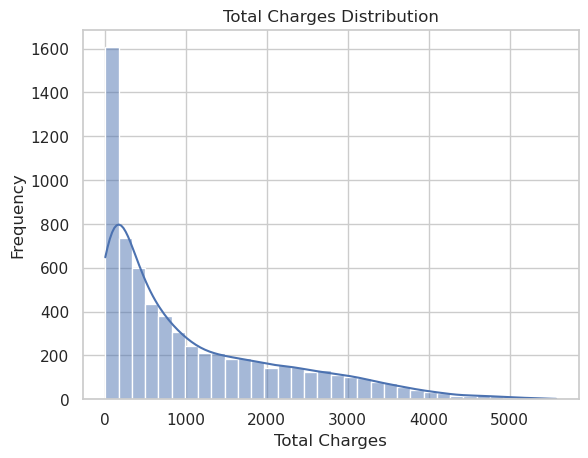

In [12]:

# Distribution of Total Charges (if you have this column)
if 'TotalCharges' in df_silver_pd.columns:
    sns.histplot(df_silver_pd['TotalCharges'], kde=True)
    plt.title('Total Charges Distribution')
    plt.xlabel('Total Charges')
    plt.ylabel('Frequency')
    plt.show()


### Churn Quick EDA

StatementMeta(, c570839b-bb19-4093-9741-7cad85615e53, 15, Finished, Available, Finished)

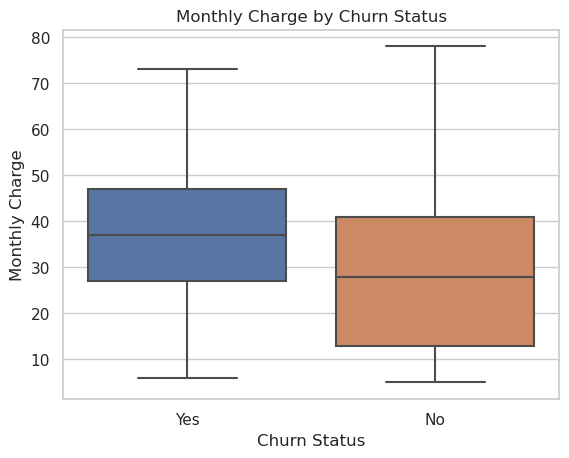

In [13]:
# Compare Monthly Charge between Churned and Non-Churned customers
sns.boxplot(x='ChurnLabel', y='MonthlyCharge', data=df_silver_pd)
plt.title('Monthly Charge by Churn Status')
plt.xlabel('Churn Status')
plt.ylabel('Monthly Charge')
plt.show()


StatementMeta(, c570839b-bb19-4093-9741-7cad85615e53, 24, Finished, Available, Finished)

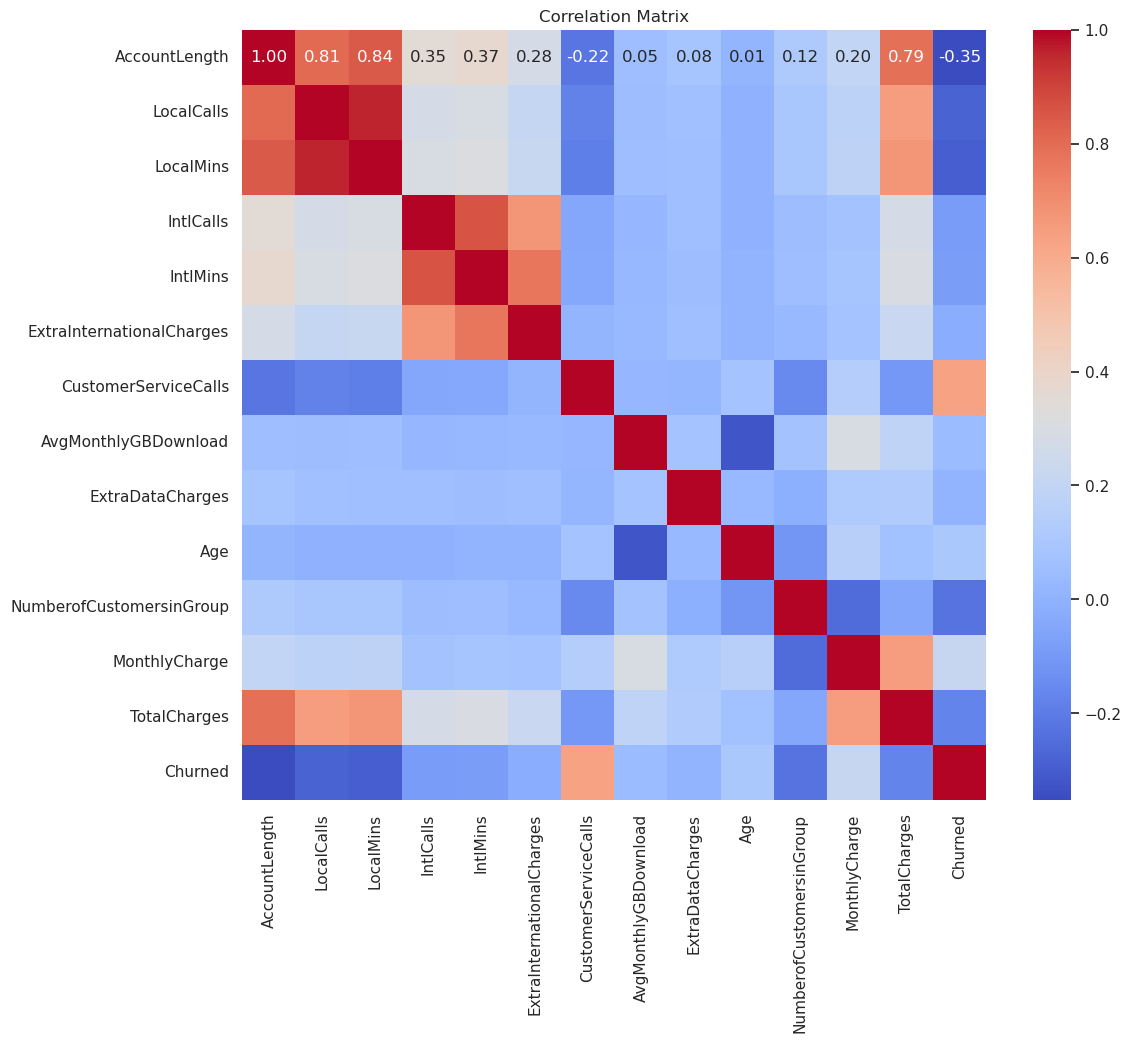

In [22]:
# Keep only numeric columns first
df_numeric = df_silver_pd.select_dtypes(include=['number'])

# Now calculate correlation matrix safely
corr = df_numeric.corr()

# Plot the heatmap
plt.figure(figsize=(12,10))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()


StatementMeta(, c570839b-bb19-4093-9741-7cad85615e53, 17, Finished, Available, Finished)

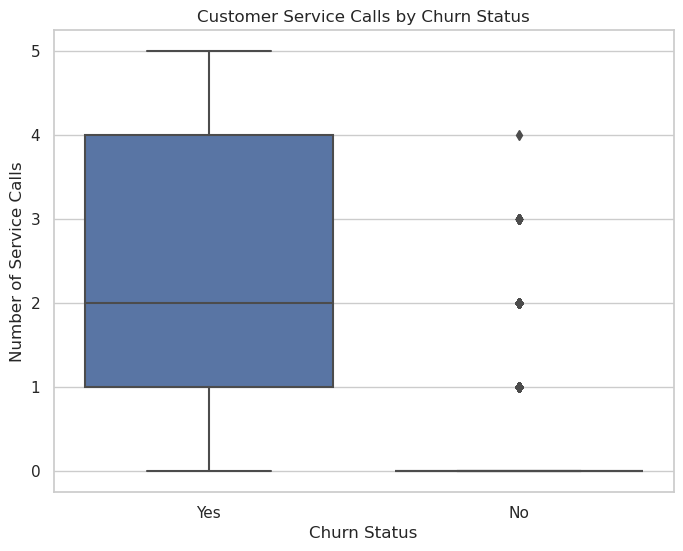

In [15]:
# Service Calls vs Churn (if you have CustomerServiceCalls column)
if 'CustomerServiceCalls' in df_silver_pd.columns:
    plt.figure(figsize=(8,6))
    sns.boxplot(x='ChurnLabel', y='CustomerServiceCalls', data=df_silver_pd)
    plt.title('Customer Service Calls by Churn Status')
    plt.xlabel('Churn Status')
    plt.ylabel('Number of Service Calls')
    plt.show()


StatementMeta(, c570839b-bb19-4093-9741-7cad85615e53, 18, Finished, Available, Finished)

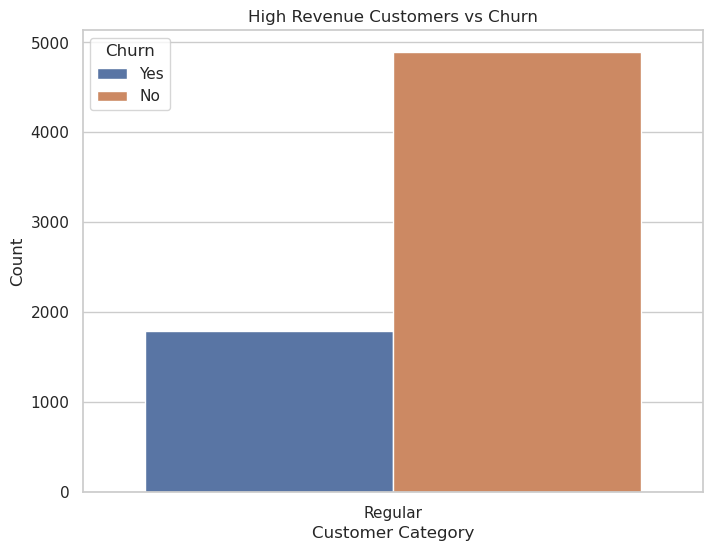

In [16]:

# HighRevenueCustomer vs Churn
if 'HighRevenueCustomer' in df_silver_pd.columns:
    plt.figure(figsize=(8,6))
    sns.countplot(x='HighRevenueCustomer', hue='ChurnLabel', data=df_silver_pd)
    plt.title('High Revenue Customers vs Churn')
    plt.xlabel('Customer Category')
    plt.ylabel('Count')
    plt.legend(title='Churn')
    plt.show()


In [17]:
# Based on findings, what we can show in Power BI report/s
print("""
🔎 Key Insights:
- Churn Rate is around X% (fill after viewing).
- High Monthly Charges may correlate with lower churn (boxplot shows).
- Service Calls are higher for churned customers.
- Age Group 'Under 30' has a higher churn percentage (to validate).
""")

StatementMeta(, c570839b-bb19-4093-9741-7cad85615e53, 19, Finished, Available, Finished)


🔎 Key Insights:
- Churn Rate is around X% (fill after viewing).
- High Monthly Charges may correlate with lower churn (boxplot shows).
- Service Calls are higher for churned customers.
- Age Group 'Under 30' has a higher churn percentage (to validate).



Does Higher Monthly Charge correlate with Lower Churn?

In [23]:
# Expect a negative correlation if higher payers churn less.
# Converted ChurnLabel to 0/1:
df_silver_pd['Churned'] = df_silver_pd['ChurnLabel'].map({'No': 0, 'Yes': 1})

# Then:
print(df_numeric['MonthlyCharge'].corr(df_numeric['Churned']))


StatementMeta(, c570839b-bb19-4093-9741-7cad85615e53, 25, Finished, Available, Finished)

0.21469123858129305


Do More Customer Service Calls mean Higher Churn?

In [24]:
# Expect a positive correlation — more calls, more churn.
print(df_numeric['CustomerServiceCalls'].corr(df_numeric['Churned']))


StatementMeta(, c570839b-bb19-4093-9741-7cad85615e53, 26, Finished, Available, Finished)

0.6355326405046672


Does Age affect Churn?

In [25]:
#  If negative, younger customers churn more.
print(df_numeric['Age'].corr(df_numeric['Churned']))


StatementMeta(, c570839b-bb19-4093-9741-7cad85615e53, 27, Finished, Available, Finished)

0.10751731660749753


Does having an International Plan affect Churn?

In [26]:
# Interpret:

# Negative = customers with International Plan stay longer.

# Positive = customers with International Plan churn more.
# Example Encoding
df_silver_pd['IntlPlanBinary'] = df_silver_pd['IntlPlan'].map({'No': 0, 'Yes': 1})

# Then check correlation
print(df_silver_pd['IntlPlanBinary'].corr(df_silver_pd['Churned']))


StatementMeta(, c570839b-bb19-4093-9741-7cad85615e53, 28, Finished, Available, Finished)

nan
